In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sqlite3 as sql

from src import convert_sql
from src import _02_create_charts as charts

connection = sql.connect('data/taylor_swift.db')
cursor = connection.cursor()

In [19]:
eras = {
    'Taylor Swift': '#A5C9A5',
    'Fearless': '#EFC180',
    'Speak Now': '#C7A8CB',
    'Red': '#7A2E39',
    '1989': '#B5E5F8',
    'reputation': '#746F70',
    'Lover': '#F7B0CC',
    'folklore': '#CDC9C1',
    'evermore': '#C5AC90',
    'Fearless (TV)': '#000000',
    'Red (TV)': '#000000',
    'Midnights': '#242E47',
    'Speak Now (TV)': '#000000',
    '1989 (TV)': '#000000',
    'Other': '#000000'
}

In [12]:
collab_count_temptables = convert_sql.sql_to_string('collab_count_temptables.sql')
cursor.executescript(collab_count_temptables)

In [13]:
collabs = pd.read_sql('SELECT * FROM collab_count_era', connection)

# Set era order to be chronological
collabs['era'] = pd.Categorical(collabs['era'], eras.keys())
collabs.sort_values('era', inplace=True)
collabs

,era,writers,producers,artists
11,Taylor Swift,7,5,1
2,Fearless,8,2,2
9,Speak Now,3,3,2
7,Red,8,9,3
0,1989,9,11,2
14,reputation,12,7,3
4,Lover,12,6,4
13,folklore,5,4,2
12,evermore,6,6,4
3,Fearless (TV),12,4,4


In [15]:
collaborator_temp_table = convert_sql.sql_to_string('02_collaborator_temp_table.sql')
cursor.executescript(collaborator_temp_table)

In [16]:
pd.read_sql('SELECT * FROM collaborator_flat LIMIT 5', connection)

,era,collaborator,writer_count,producer_count,artist_count,total_songs_writer,total_songs_producer,total_songs_artist,total_credits
0,1989,Ali Payami,1,1,0,3,2,0,5
1,1989,Erik Ron,1,0,0,1,0,0,1
2,1989,ILYA,0,1,0,0,1,0,1
3,1989,Imogen Heap,1,1,0,2,2,0,4
4,1989,Jack Antonoff,3,3,0,51,69,0,120


In [17]:
collaborators_query = convert_sql.sql_to_string('02_collaborators_final.sql')
collaborators = pd.read_sql(collaborators_query, connection)

# Set collaborator order to have 'Other Collaborators' appear last
collaborator_order = sorted(set(collaborators['collaborator']) - {'Other Collaborators'}) + ['Other Collaborators']
collaborators['collaborator'] = pd.Categorical(collaborators['collaborator'], categories=collaborator_order, ordered=True)

# Set era order to be chronological
collaborators['era'] = pd.Categorical(collaborators['era'], eras.keys())
collaborators.sort_values('era', inplace=True)
collaborators.head(10)

,era,collaborator,writer_count,producer_count,artist_count
63,Taylor Swift,Robert Ellis Orrall,3,3,0
62,Taylor Swift,Other Collaborators,5,3,0
61,Taylor Swift,Nathan Chapman,0,10,0
60,Taylor Swift,Liz Rose,7,0,0
12,Fearless,Liz Rose,6,0,0
13,Fearless,Nathan Chapman,0,18,0
14,Fearless,Other Collaborators,6,0,1
55,Speak Now,Other Collaborators,2,1,1
54,Speak Now,Nathan Chapman,0,17,0
38,Red,Dan Wilson,2,2,0


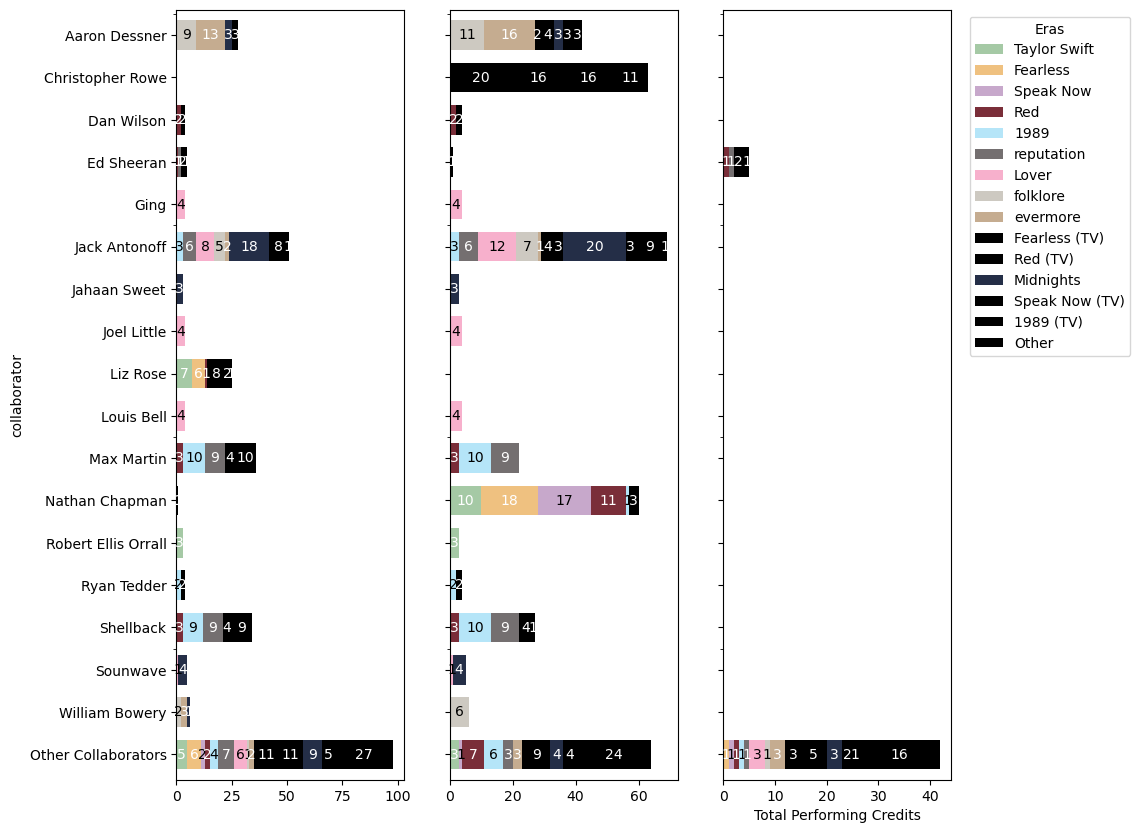

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True)
writers_chart = charts.stacked_bar_chart('barh', collaborators, 'collaborator', 'writer_count', 'era', 
                                         eras, '', 'Total Writing Credits', 'Collaborator', axes[0], False, '')
producers_chart = charts.stacked_bar_chart('barh', collaborators, 'collaborator', 'producer_count', 'era', 
                                         eras, '', 'Total Producing Credits', 'Collaborator', axes[1], False, '')
artists_chart = charts.stacked_bar_chart('barh', collaborators, 'collaborator', 'artist_count', 'era', 
                                         eras, '', 'Total Performing Credits', 'Collaborator', axes[2], True, 'Eras')

In [21]:
connection.close()